# Assignment 3: Speech Emotion Recognition

## Content
1. [Download the Dataset and Understand the Format](#1)
    * [Load Crema Dataset](#2)
    * [Plotting each class](#3)
    * [Listen to each class](#4)
2. [Create the Feature Space](#5)
    * [Audio Augmentation](#7)
        * [Original Audio](#4)
        * [Noised Audio](#8)
        * [Streched Audio](#10)
        * [Shifted Audio](#11)
        * [Pitched Audio](#12)
    * [Feature Extraction](#13)
    * [Processing](#14)
4. [Including Analyzed Audio Features](#15)
5. [Processing Analyzed Data for Training](#16)
    * [Train, Test and Validation Spliting](#17)
    * [Tuning for Training](#18)
6. [Begin Training](#19)
7. [Drawing Charts](#20)
    * [Accuracy Charts](#21)
    * [Loss Charts](#22)
8. [Testing Model and Test Results](#24)
    * [Confusion Matrix](#25)

### Including Libraries

In [2]:
import numpy as np
import pandas as pd 
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import IPython
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder,StandardScaler
import os
import math
from sklearn import preprocessing
from alive_progress import alive_bar
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset , DataLoader , DataLoader2
import gc

### Specify dataset path

In [3]:
# If you are using google colab, set drive to True and set the path to the zip file
# if no, set drive to False and set the path to the folder
Crema_Path = '../Crema/'

drive = False
path_to_zip = "/content/drive/My Drive/path/to/Data.Zip"
if drive:
    from google.colab import drive
    drive.mount('/content/drive')
    !unzip path_to_zip -d "/content"
    Crema_Path='/content/Crema'

### Choose which device to train

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

cpu


<a id="1"></a>
# Download the Dataset and Understand the Format 

<a id="2"></a>
## Load Crema Dataset

In [5]:
crema=[]
for wav in os.listdir(Crema_Path):
    emotion=wav.partition(".wav")[0].split('_')
    if emotion[2]=='SAD':
        crema.append(('sad',Crema_Path+'/'+wav))
    elif emotion[2]=='ANG':
        crema.append(('angry',Crema_Path+'/'+wav))
    elif emotion[2]=='DIS':
        crema.append(('disgust',Crema_Path+'/'+wav))
    elif emotion[2]=='FEA':
        crema.append(('fear',Crema_Path+'/'+wav))
    elif emotion[2]=='HAP':
        crema.append(('happy',Crema_Path+'/'+wav))
    elif emotion[2]=='NEU':
        crema.append(('neutral',Crema_Path+'/'+wav))
    else:
        crema.append(('unknown',Crema_Path+'/'+wav))
Crema_df=pd.DataFrame.from_dict(crema)
Crema_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Crema_df.head()

,Emotion,File_Path
0,angry,../Crema//1001_DFA_ANG_XX.wav
1,disgust,../Crema//1001_DFA_DIS_XX.wav
2,fear,../Crema//1001_DFA_FEA_XX.wav
3,happy,../Crema//1001_DFA_HAP_XX.wav
4,neutral,../Crema//1001_DFA_NEU_XX.wav


In [6]:
emotion_colors = {'disgust':'blue','happy':'green','sad':'black','neutral':'aqua','fear':'purple','angry':'red','surprise':'yellow'}
emotion_names=Crema_df['Emotion'].unique()
emotion_names

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
      dtype=object)

In [7]:
def wave_plot(data,sr,emotion,color):
    plt.figure(figsize=(7,4))
    plt.title(f'{emotion} emotion for waveplot',size=17)
    plt.plot(data, color=color)
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()


<a id="3"></a>
## Plotting each class

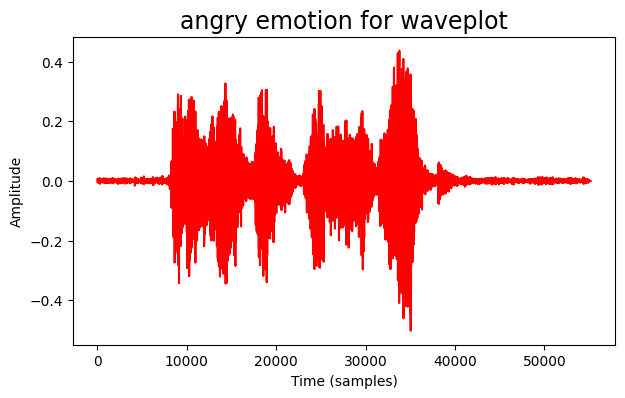

-------------------------------------------------------------


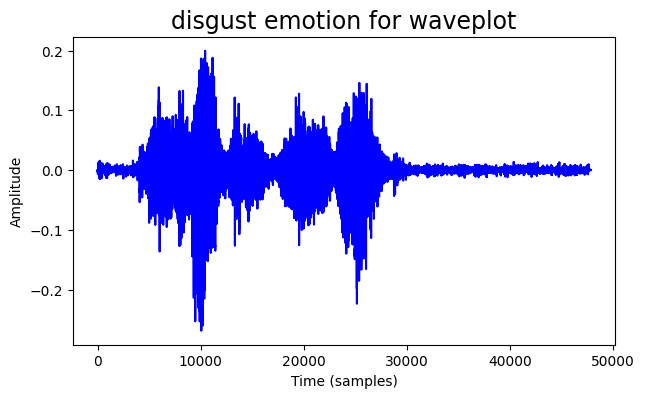

-------------------------------------------------------------


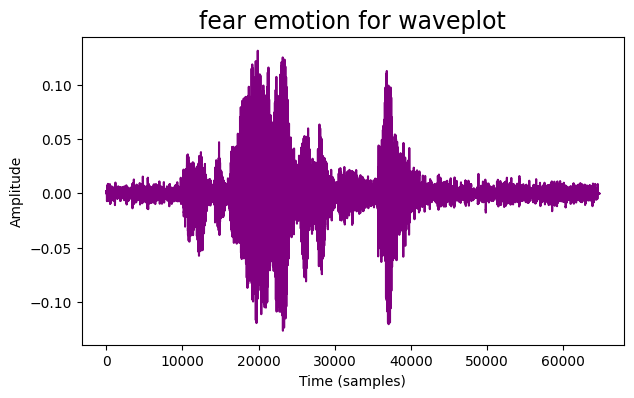

-------------------------------------------------------------


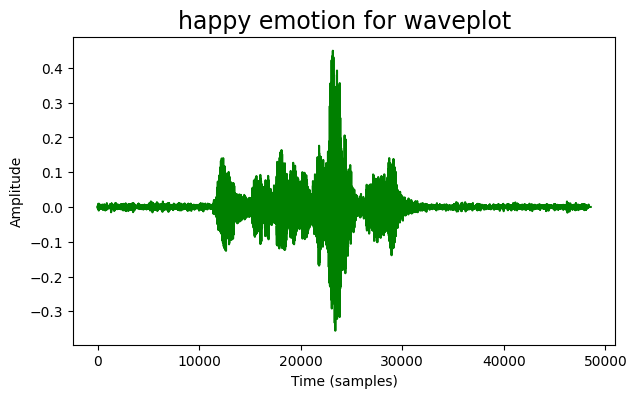

-------------------------------------------------------------


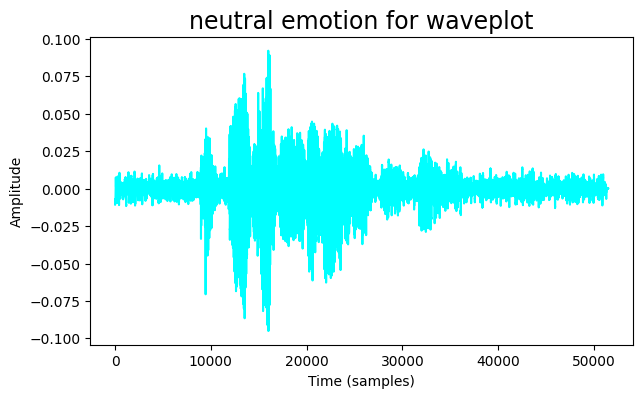

-------------------------------------------------------------


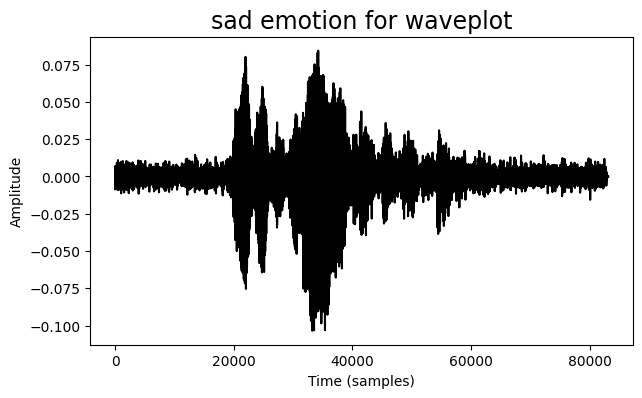

-------------------------------------------------------------


In [23]:
paths = []
for emotion in emotion_names:
    path=np.array(Crema_df['File_Path'][Crema_df['Emotion']==emotion])[11]
    data,sr=librosa.load(path)
    wave_plot(data,sr,emotion,emotion_colors[emotion])
    IPython.display.Audio(path)
    print("-------------------------------------------------------------")
    paths.append(path)


<a id="4"></a>
## Listen to each class

In [24]:
print("Sound of emotion: ",emotion_names[0])
IPython.display.Audio(paths[0])

Sound of emotion:  angry


In [25]:
print("Sound of emotion: ",emotion_names[1])
IPython.display.Audio(paths[1])

Sound of emotion:  disgust


In [26]:
print("Sound of emotion: ",emotion_names[2])
IPython.display.Audio(paths[2])

Sound of emotion:  fear


In [27]:
print("Sound of emotion: ",emotion_names[3])
IPython.display.Audio(paths[3])

Sound of emotion:  happy


In [28]:
print("Sound of emotion: ",emotion_names[4])
IPython.display.Audio(paths[4])

Sound of emotion:  neutral


In [29]:
print("Sound of emotion: ",emotion_names[5])
IPython.display.Audio(paths[5])

Sound of emotion:  sad


<a id="13"></a>
## Feature Extraction

In [32]:
def zero_crossing_rate(y, frame_length=2048, hope_length=512):
  return librosa.feature.zero_crossing_rate(y=y, frame_length=frame_length, hop_length=hope_length).flatten()
#   return np.mean(librosa.feature.zero_crossing_rate(y=y, frame_length=frame_length, hop_length=hope_length).T,axis=0)

def energy(y, frame_length=2048, hope_length=512):
  energy = []
  for hope in range(0, y.shape[0], hope_length):
    energy.append(np.sum(np.power(y[hope:hope+frame_length], 2)))

  energy = np.array(energy)
  return energy/frame_length

# amplitude envelope
def amplitude_envelope(y, frame_length=2048, hope_length=512):
  amplitude_envelope = []
  for hope in range(0, y.shape[0], hope_length):
    amplitude_envelope.append(np.max(np.abs(y[hope:hope+frame_length])))

  amplitude_envelope = np.array(amplitude_envelope)
  return amplitude_envelope

def mel_specto(y, sr):
  return librosa.feature.melspectrogram(y=y, sr=sr)


In [33]:
def get_features(path,duration = 2.2 , offset = 0.2):
  
  y, sr = librosa.load(path= path , duration=duration , offset = offset)
  
  # stretch audio
  if len(y) < math.floor(duration *sr):
    temp_ar = np.zeros(int(math.floor(duration *sr) - len(y)))
    y = np.concatenate((y,temp_ar))

  features_time = np.hstack((
      y,
      zero_crossing_rate(y),
      energy(y),
      amplitude_envelope(y)
      ))
  
  features_spect = mel_specto(y, sr)
  del(y)
  del(sr)
  
  return features_time,features_spect

In [34]:
def load_data(df):
    X_time,X_spect, y = [], [], []

    print('loading')
    for path,emotion,index in zip(Crema_df.File_Path,Crema_df.Emotion,range(df.File_Path.shape[0])):
        time_features,freq_features = get_features(path)
        X_time.append(time_features)
        X_spect.append(freq_features)
        y.append(emotion)
        del(time_features)
        del(freq_features)
        
    print('Done')
    return X_time,X_spect, y

In [3]:
features_time = np.load('features_time.npy')
features_spect = np.load('features_spect.npy')
labels = np.load('labels.npy')

In [35]:
features_time,features_spect, labels = load_data(Crema_df)

loading
Done


In [39]:
# visualize the features
def visualize_features(features, labels, emotion_names):
    for i in range(len(features)):
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(features[i], x_axis='time')
        plt.colorbar()
        plt.title(f'{labels[i]} emotion')
        plt.tight_layout()
        plt.show()

In [53]:
# make picture out of time features
def visualize_time_features(features, labels, emotion_names):
    for i in range(len(features)):
        plt.figure(figsize=(10, 4))
        plt.plot(features[i])
        plt.title(f'{labels[i]} emotion')
        plt.tight_layout()
        plt.show()

In [10]:
x = np.array(features_time)

In [11]:
x_norm = (x-np.min(x))/(np.max(x)-np.min(x))


In [12]:
x255 = x_norm*255

In [13]:
x255 = x255.astype('uint8')

In [15]:
x255[0]

array([128, 128, 128, ..., 129, 129, 129], dtype=uint8)

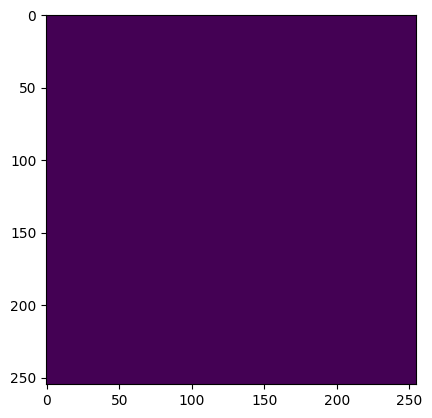

In [14]:
import cv2
# show x255 as image
from PIL import Image
img = Image.fromarray(x255[0])
img = img.resize((255,255))
# show image using matplotlib
plt.imshow(img)

In [44]:
# change values in time features to be between 0 and 255 and convert them to gray scale image and show it
def visualize_time_features_gray(features, labels, emotion_names):
    for i in range(len(features)):
        # scale values to be between 0 and 255
        features[i] = np.
        img = np.reshape(features[i], (243500, 243500))
        img = img.astype(np.uint8)
        img = cv2.resize(img, (224, 224))
        
        plt.figure(figsize=(10, 4))
        plt.plot(img)
        plt.title(f'{labels[i]} emotion')
        plt.tight_layout()
        plt.show()

In [ ]:
visualize_time_features(features_time, labels, emotion_names)

In [83]:
# save features
np.save('features_time.npy', features_time)
np.save('features_spect.npy', features_spect)
np.save('labels.npy', labels)

In [118]:
# splitting  dataset to 70% trian and validation and 30% test
x_train_time, x_test_time, y_train_time, y_test_time = train_test_split(features_time, labels,test_size=0.3, stratify = labels, random_state=42 )

# splitting train set to 95% trian and 5% validation
x_train_time, x_val_time, y_train_time, y_val_time = train_test_split(x_train_time, y_train_time,test_size=0.05, stratify =y_train_time , random_state=42)

In [119]:
np.array(x_train_time).shape

(4948, 48606)

In [120]:
# Label encoding

label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'Emotion'. 

y_train_time= label_encoder.fit_transform(y_train_time) 
y_val_time = label_encoder.transform(y_val_time) 
y_test_time = label_encoder.transform(y_test_time) 

In [121]:
scaler = preprocessing.StandardScaler()
x_train_time = scaler.fit_transform(x_train_time)
x_test_time = scaler.transform(x_test_time)
x_val_time = scaler.transform(x_val_time)

In [122]:
x_train_time = np.array(x_train_time ).reshape(len(x_train_time),1,-1)
x_val_time = np.array(x_val_time).reshape(len(x_val_time),1,-1)
x_test_time = np.array(x_test_time).reshape(len(x_test_time),1,-1)

In [123]:
x_train_time.shape


(4948, 1, 48606)

In [158]:
# splitting  dataset to 70% trian and validation and 30% test

x_train_freq, x_test_freq, y_train_freq, y_test_freq = train_test_split(features_spect, labels,test_size=0.3, stratify = labels, random_state=42)

# splitting train set to 95% trian and 5% validation
x_train_freq, x_val_freq, y_train_freq, y_val_freq = train_test_split(x_train_freq, y_train_freq,test_size=0.05, stratify =y_train_freq , random_state=42)

In [160]:
np.array(x_test_freq).shape


(2233, 128, 95)

In [159]:
# Label encoding

label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'Emotion'. 

y_train_freq= label_encoder.fit_transform(y_train_freq) 
y_val_freq = label_encoder.transform(y_val_freq) 
y_test_freq = label_encoder.transform(y_test_freq) 

In [142]:
class MyDataset(Dataset):
  def __init__(self , array , labels):
        self.array = array
        self.labels = labels

  def __getitem__(self,index):
    audio_features = self.array[index]
    return torch.tensor(audio_features).float() , torch.tensor(int(self.labels[index]))

  def __len__(self):
    return len(self.array)

In [143]:
class Model(nn.Module):
  def __init__(self):
    # TODO : Check layers in_channel numbers
    super(Model , self).__init__()
    self.conv1 = nn.Conv1d(in_channels=1 , out_channels=512 , kernel_size=5 , stride=1)
    self.bn1 = nn.BatchNorm1d(512)
    self.conv2 = nn.Conv1d(in_channels=512 , out_channels=512 ,kernel_size=5 , stride=1)
    self.bn2 = nn.BatchNorm1d(512)
    
    self.conv3 = nn.Conv1d(in_channels=512 , out_channels=256 , kernel_size=5 , stride=1)
    self.bn3 = nn.BatchNorm1d(256)    
    
    self.conv4 = nn.Conv1d(in_channels=256 , out_channels=256 , kernel_size=5 , stride=1)
    self.bn4 = nn.BatchNorm1d(256)
    
    
    self.conv5 = nn.Conv1d(in_channels=256 , out_channels=128 , kernel_size=5 , stride=1)
    self.bn5 = nn.BatchNorm1d(128)

    # fully connected layers
    self.fc1 = nn.Linear(in_features=193536 , out_features=256)
    self.fc2 = nn.Linear(in_features=256 , out_features=128)
        
    self.fc3 = nn.Linear(in_features=128 , out_features=6)

  def forward(self,x):
#     gc.collect()
#     torch.cuda.empty_cache()
    # print('X Shape: {}'.format(x.shape))
    x = self.conv1(x)
    # print('Conv1 Shape: {}'.format(x.shape))

    x = F.relu(self.bn1(x))
    x = F.max_pool1d(x,5,2)

    x = self.conv2(x)
    # print('Conv2 Shape: {}'.format(x.shape))
    x = F.relu(self.bn2(x))
    x = F.max_pool1d(x,5,2)

    x = self.conv3(x)
    # print('Conv3 Shape: {}'.format(x.shape))
    x = F.relu(self.bn3(x))
    x = F.max_pool1d(x,5,2)

    x = self.conv4(x)
    # print('Conv4 Shape: {}'.format(x.shape))
    x = F.relu(self.bn4(x))    
    x = F.max_pool1d(x,5,2)

    x = self.conv5(x)
    # print('Conv5 Shape: {}'.format(x.shape))
    x = F.relu(self.bn5(x))
    x = F.max_pool1d(x,5,2)
    

    x = torch.flatten(x,1)
#     print("FLATTEN {}".format(x.shape))
    
    x = self.fc1(x)
    # print('FC1 Shape: {}'.format(x.shape))
    x = F.relu(x)
#     x = self.dropout2(x)

    x = self.fc2(x)
    # print('FC1 Shape: {}'.format(x.shape))
    x = F.relu(x)
    
    x = self.fc3(x)
    # print('FC2 Shape: {}'.format(x.shape))
    output = F.log_softmax(x , dim=1)
    # print('output: {}'.format(output.shape))
    return output

In [173]:
def trainModel(model , dataloader , optimizer,current_epoch , loss_vec , acc_vec):
  
  model.train()

  loss_fun = nn.CrossEntropyLoss()
  total_loss = 0
  num_correct = 0

  with alive_bar(len(dataloader), force_tty=True) as bar:
    for batch_idx , (data , label) in enumerate(dataloader):
#       gc.collect()
#       torch.cuda.empty_cache()
      
      
      data = data.to(device)
      label = label.to(device)

      optimizer.zero_grad()
      output = model(data)
      
      loss = loss_fun(output, label)
     
      total_loss +=  loss.item()
      loss.backward()
      optimizer.step()
      

      pred = torch.argmax(output, 1)
      num_correct +=  pred.eq(label.data).cpu().sum()

#       if batch_idx % 200 == 0: #print training stats
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 current_epoch, batch_idx * len(data), len(dataloader.dataset),
#                 100. * batch_idx / len(dataloader), loss.item()))
      bar()

    acc = 100 * num_correct.to(torch.float32) / len(dataloader.dataset)
    acc_vec.append(float(acc))
    loss_vec.append(float(total_loss/len(dataloader)))
    
    print('Train Epoch : {} |  | loss = {}  train acc. = {}'.format(current_epoch , total_loss/len(dataloader) , acc))
    

In [145]:
def validateModel(model , dataloader , loss_vector,acc_vector):
  
  model.eval()

  # pred,labels = [] , []
  loss_fun = nn.CrossEntropyLoss()
  total_loss = 0
  # total_acc = 0
  num_correct = 0
  with torch.no_grad():
    for (data , label) in dataloader:
      # clear gpu cache
#       gc.collect()
#       torch.cuda.empty_cache()
      
      data = data.to(device)
      label = label.to(device)
      
      output = model(data)
      
      loss = loss_fun(output, label)
    
      total_loss = total_loss + loss.data.item()
      # get index of max log prob.
      pred = torch.argmax(output, 1)
      num_correct +=  pred.eq(label.data).cpu().sum()
   
  
  val_loss = total_loss / len(dataloader)
  loss_vector.append(val_loss)

  acc = 100 * num_correct.to(torch.float32) / len(dataloader.dataset)
  acc_vector.append(float(acc))

  print('Validation set Average loss : {}  , Acc. : | {} / {} | with {} %'.format(val_loss, num_correct, len(dataloader.dataset), acc ))

In [146]:
def testModel(model , dataloader):
  
  model.eval()
  pred_vec , labels_vec = [] , []  

  num_correct = 0
  with torch.no_grad():
    for (data , label) in dataloader:
      gc.collect()
      torch.cuda.empty_cache()
      
      data = data.to(device)
      label = label.to(device)
      
      output = model(data)

      # get index of max log prob.
      pred = torch.argmax(output, 1)
      pred_vec += pred
      labels_vec+= label.data
      num_correct +=  pred.eq(label.data).cpu().sum()
        

  acc = 100 * num_correct.to(torch.float32) / len(dataloader.dataset)
  

  print('Test set Average Accuracy : | {} / {} | with {} %'.format(num_correct, len(dataloader.dataset), acc ))
  return labels_vec , pred

In [169]:
def saveModel(model , file_name):
    torch.save(model.state_dict() , file_name)
    
def loadModel(file_name , time_domain = True):
    checkpoint = torch.load(file_name)
    if time_domain:
        model = Model().to(device)
        model.load_state_dict(checkpoint)
    else : 
        model = FreqModel().to(device)
        model.load_state_dict(checkpoint)
    return model

In [148]:
def graphs_train_val_acc(train_acc,val_acc):
    plt.plot(val_acc, label='validation accuracy')
    plt.plot(train_acc, label='train accuracy')
    plt.title('Training history')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
#     plt.ylim([0 ,1])

In [149]:
def graphs_train_val_loss(train_loss , val_loss):
    plt.plot(val_loss, label='validation Loss')
    plt.plot(train_loss, label='train Loss')
    plt.title('Training history')
    plt.ylabel('Accuracy Loss')
    plt.xlabel('Epoch')
    plt.legend()

In [150]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [151]:
train_dataset = MyDataset(x_train_time , y_train_time)
validation_dataset = MyDataset(x_val_time , y_val_time)
test_dataset = MyDataset(x_test_time , y_test_time)

In [152]:
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset , batch_size = BATCH_SIZE ,shuffle = True )
validation_loader = DataLoader(validation_dataset , batch_size = BATCH_SIZE ,shuffle = True )
test_loader = DataLoader(test_dataset , batch_size = BATCH_SIZE ,shuffle = True )

In [153]:
# del(model)
# del(optimizer)
# del(sheduler)
model = Model().to(device)
EPOCHS = 25
learning_rate = 0.001
weight_decay=0.0001
optimizer = torch.optim.Adam(model.parameters() , learning_rate )
sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer , patience=5 , threshold=1e-4)

In [154]:
gc.collect()
torch.cuda.empty_cache()

In [155]:
val_loss_vec , val_acc_vec = [] , []
train_loss_vec , train_acc_vec = [] , []
lr_vec = []

In [ ]:
for e in range(EPOCHS):
  gc.collect()
  torch.cuda.empty_cache()
  lr_vec.append(get_lr(optimizer))
  
  trainModel(model , train_loader , optimizer , e+1 , train_loss_vec  ,train_acc_vec)
  gc.collect()
  torch.cuda.empty_cache()

  validateModel(model , validation_loader , val_loss_vec  ,val_acc_vec )
  sheduler.step(val_loss_vec[e])
  print()
  if e%10==10:
        saveModel(model , 'time_domain_checkpoint_{}.pth'.format(e))

In [161]:
class FreqModel(nn.Module):
  def __init__(self):
    # TODO : Check layers in_channel numbers
    super(FreqModel , self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1 , out_channels=512 , kernel_size=5 , stride=1)
    self.bn1 = nn.BatchNorm2d(512)
    self.conv2 = nn.Conv2d(in_channels=512 , out_channels=512 , kernel_size=5 , stride=1)
    self.bn2 = nn.BatchNorm2d(512)
    self.conv3 = nn.Conv2d(in_channels=512 , out_channels=128 , kernel_size=5 , stride=1)
    self.bn3 = nn.BatchNorm2d(128)

    # fully connected layers
    self.fc1 = nn.Linear(in_features=5760 , out_features=256)
    self.fc2 = nn.Linear(in_features=256 , out_features=6)

  def forward(self,x):
    gc.collect()
    torch.cuda.empty_cache()
    # print('X Shape: {}'.format(x.shape))
    x = self.conv1(x)
    # print('Conv1 Shape: {}'.format(x.shape))

    x = F.relu(self.bn1(x))
    x = F.max_pool2d(x,5,2)

    x = self.conv2(x)
    # print('Conv2 Shape: {}'.format(x.shape))
    x = F.relu(self.bn2(x))
    x = F.max_pool2d(x,5,2)

    x = self.conv3(x)
    # print('Conv3 Shape: {}'.format(x.shape))
    x = F.relu(self.bn3(x))
    x = F.max_pool2d(x,5,2)
    x = torch.flatten(x,1)
#     print("FLATTEN {}".format(x.shape))
    x = self.fc1(x)
    # print('FC1 Shape: {}'.format(x.shape))
    x = F.relu(x)
    x = self.fc2(x)
    # print('FC2 Shape: {}'.format(x.shape))
    output = F.log_softmax(x , dim=1)
    # print('output: {}'.format(output.shape))
    return output

In [162]:
del(model)
del(optimizer)
del(sheduler)
del(train_dataset,validation_dataset,test_dataset)

In [163]:
n = len(x_train_freq[0])
m = len(x_train_freq[0][0])
for i in range(len(x_train_freq)):
  x_train_freq[i] = x_train_freq[i].reshape(1 , n ,m)
  

for i in range(len(x_val_freq)):
  x_val_freq[i] = x_val_freq[i].reshape(1 , n ,m)

for i in range(len(x_test_freq)):
  x_test_freq[i] = x_test_freq[i].reshape(1 , n ,m)

In [164]:
np.array(x_train_freq).shape


(4948, 1, 128, 95)

In [165]:
train_dataset = MyDataset(x_train_freq , y_train_freq)
validation_dataset = MyDataset(x_val_freq , y_val_freq)
test_dataset = MyDataset(x_test_freq , y_test_freq)

In [166]:
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset , batch_size = BATCH_SIZE ,shuffle = True )
validation_loader = DataLoader(validation_dataset , batch_size = BATCH_SIZE ,shuffle = True )
test_loader = DataLoader(test_dataset , batch_size = BATCH_SIZE ,shuffle = True )

In [167]:
model_freq = FreqModel().to(device)
EPOCHS = 5
learning_rate = 0.001
optimizer = torch.optim.Adam(model_freq.parameters() , learning_rate , weight_decay=0.0001)
sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer , patience=5 , threshold=1e-4)

In [168]:
val_loss_vec , val_acc_vec = [] , []
train_loss_vec , train_acc_vec = [] , []

In [174]:
for e in range(20):
  print('--- Start Epoch Number : {} ----'.format(e+1))
  gc.collect()
  torch.cuda.empty_cache()
  
  trainModel(model_freq , train_loader , optimizer , e+1 , train_loss_vec ,train_acc_vec )
  gc.collect()
  torch.cuda.empty_cache()

  validateModel(model_freq , validation_loader , val_loss_vec  ,val_acc_vec )
  sheduler.step(val_loss_vec[e])
  print('--- End Epoch Number : {} ----'.format(e+1))
  print()

--- Start Epoch Number : 1 ----
on 310: Train Epoch : 1 |  | loss = 1.6972705045054035  train acc. = 29.931285858154297
|████████████████████████████████████████| 310/310 [100%] in 31:03.6 (0.17/s)   
